# Import libraries

In [1]:
# --- Standard libraries ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Geospatial libraries ---
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely import wkt
from shapely.geometry import Point

# --- Spatial analysis ---
from esda.moran import Moran
from libpysal.weights import DistanceBand, KNN, Queen, Rook
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# --- Machine learning / statistics ---
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from scipy.spatial import cKDTree
from scipy.stats import jarque_bera

# --- Display ---
from IPython.display import display, Math

# Define regions

In [2]:
# define central_suburbs
christchurch_city = [
    "Addington", "Aidanfield", "Aranui", "Avondale", "Avonhead", "Avonside",
    "Beckenham", "Belfast", "Bexley", "Bishopdale", "Bromley", "Broomfield",
    "Burnside", "Burwood", "Bryndwr", "Cashmere", "Casebrook", "Central City",
    "Charteris Bay", "Christchurch Central", "Cracroft", "Dallington", "Diamond Harbour",
    "Edgeware", "Fendalton", "Governors Bay", "Halswell", "Harewood", "Hei Hei",
    "Hillmorton", "Hoon Hay", "Huntsbury", "Hornby", "Ilam", "Islington",
    "Kennedys Bush", "Linwood", "Lyttelton", "Mairehau", "Mairehau North", "Marshland",
    "Merivale", "Mount Pleasant", "New Brighton", "North Beach", "Northcote", "Northwood",
    "Opawa", "Papanui", "Parklands", "Phillipstown", "Pineacres", "Redcliffs",
    "Redwood", "Riccarton", "Richmond", "Russley", "Shirley", "Somerfield",
    "Sockburn", "Southshore", "St Albans", "St Martins", "Strowan", "Spreydon",
    "Sydenham", "Upper Riccarton", "Wainoni", "Waimairi Beach", "Waltham", "Westmorland",
    "Wigram", "Woolston", "Yaldhurst"
]

# define the centre resions of CHC, i.e. CHC central and suburbs adjacent to it
central_and_adjacent_suburbs = [
    "Christchurch Central", "St Albans", "Edgeware", "Merivale", "Fendalton",
    "Riccarton", "Addington", "Spreydon", "Sydenham", "Waltham",
    "Phillipstown", "Linwood", "Richmond"
]

# define the coordination of the centre of CHC
cathedral_coords_proj = (1570619.145, 5180170.479)

# Import files and data

In [3]:
roads = gpd.read_file(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\lds-nz-primary-land-parcels-SHP\nz-primary-land-parcels.shp")      
liquor_store_original = gpd.read_file(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\vwLicenceDetailPoints20240924\vwLicenceDetailPoints20240924.shp")  
CHC_address = gpd.read_file(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\lds-nz-addresses-SHP\nz-addresses.shp")
property_address_original=pd.read_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\Christchurch property sales v2.xlsx")

# Data preparation

### clean data of property address by deleting null values

In [4]:
sub_set=['Site Coverage','Land Area m?Land$','Sale Index', 'St.No','Sale Index']

sale_price=property_address_original['St.No']
Q1=sale_price.quantile(0.25)
Q3=sale_price.quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
condition_1=~property_address_original['Category'].str[:2].isin(['RP', 'RR', 'RV', 'RB', 'RM'])   # filter out some property types
condition_2=property_address_original[sub_set].notna().all(axis=1)  # filter out null 
condition_3=sale_price.between(lower_bound,upper_bound)  # filter out outliers
property_address_original=property_address_original[condition_1 & condition_2 & condition_3]

### extract all addresses of liquor stores by filtering

In [5]:
liquor_store_original=liquor_store_original.drop_duplicates(subset='StreetAd_3',keep='last')
condition_1=liquor_store_original.Purpose=='Off-licence liquor store'
condition_2=liquor_store_original.Purpose=='Off-licence supermarket'
liquor_store=liquor_store_original.loc[condition_1]
supermarket=liquor_store_original.loc[condition_2]

### match location of property addresses

In [6]:
condition1=CHC_address['full_add_1'].isin(property_address_original['Address Complete'])
condition2=CHC_address['suburb_loc'].isin(christchurch_city)
property_address=CHC_address[condition1&condition2].drop_duplicates(subset='full_add_1').reset_index(drop=True)

### Rename Column

In [7]:
property_address=pd.merge(property_address,property_address_original,left_on='full_add_1',right_on='Address Complete',how='left')
property_address=property_address[['Sale.Date','full_add_1','geometry','Site Coverage','Land Area m?Land$','Sale Index','St.No']]
new_column_name={
    'Sale.Date':'date',
    'full_add_1':'address',
    'Site Coverage':'building_area',
    'Land Area m?Land$':'nonbuilding_area',
    'Sale Index':'age',
    'St.No':'sale_price'}
property_address=property_address.rename(columns=new_column_name)
property_address['age'] = pd.to_numeric(property_address['age'], errors='coerce')

liquor_store=liquor_store[['address_1','geometry']].rename(columns={'address_1':'address'}).reset_index(drop=True)
supermarket=supermarket[['address_1','geometry']].rename(columns={'address_1':'address'}).reset_index(drop=True)

### added columns: Distance to the nearest liqor store from property address, the distance to city centre

In [8]:
gdf_a=property_address
gdf_b=liquor_store
gdf_c=supermarket

a_coords = np.array(list(gdf_a.geometry.apply(lambda geom: (geom.x, geom.y))))
b_coords = np.array(list(gdf_b.geometry.apply(lambda geom: (geom.x, geom.y))))
c_coords = np.array(list(gdf_c.geometry.apply(lambda geom: (geom.x, geom.y))))
tree_liqor = cKDTree(b_coords)
tree_supermarket = cKDTree(c_coords)
distances, indices = tree_liqor.query(a_coords, k=1)
gdf_a['nearest_dist_liquor'] = distances.round(2)      # unit: metre
distances, indices = tree_supermarket.query(a_coords, k=1)
gdf_a['nearest_dist_supermarket'] = distances.round(2)      # unit: metre

gdf_a=property_address
property_address.head()

,date,address,geometry,building_area,nonbuilding_area,age,sale_price,nearest_dist_liquor,nearest_dist_supermarket
0,31/10/2023,"92 Mustang Avenue, Wigram, Christchurch",POINT (1563239.448 5177508.159),240,602,201.0,960000,966.20,1073.99
1,29/03/2023,"78 Kerrs Road, Avonside, Christchurch",POINT (1574263.834 5180981.602),104,774,194.0,345000,1202.10,1176.15
2,6/12/2023,"374A Pages Road, Aranui, Christchurch",POINT (1576051.79 5181730.722),43,0,197.0,280000,2199.24,982.50
3,23/12/2023,"64 Tovey Street, New Brighton, Christchurch",POINT (1578120.564 5181665.05),91,630,194.0,758500,1064.41,1216.90
4,16/03/2023,"5/6 Hendon Street, Edgeware, Christchurch",POINT (1571607.246 5182195.933),60,0,197.0,325000,495.76,964.17


In [9]:
coords = np.array(list(property_address['geometry'].apply(lambda geom: (geom.x, geom.y))))
dist_to_cathedral = np.sqrt((coords[:,0] - cathedral_coords_proj[0])**2 + 
                            (coords[:,1] - cathedral_coords_proj[1])**2)
property_address['dist_to_cathedral'] = dist_to_cathedral.round(2)
property_address.head()

,date,address,geometry,building_area,nonbuilding_area,age,sale_price,nearest_dist_liquor,nearest_dist_supermarket,dist_to_cathedral
0,31/10/2023,"92 Mustang Avenue, Wigram, Christchurch",POINT (1563239.448 5177508.159),240,602,201.0,960000,966.20,1073.99,7845.25
1,29/03/2023,"78 Kerrs Road, Avonside, Christchurch",POINT (1574263.834 5180981.602),104,774,194.0,345000,1202.10,1176.15,3733.86
2,6/12/2023,"374A Pages Road, Aranui, Christchurch",POINT (1576051.79 5181730.722),43,0,197.0,280000,2199.24,982.50,5652.26
3,23/12/2023,"64 Tovey Street, New Brighton, Christchurch",POINT (1578120.564 5181665.05),91,630,194.0,758500,1064.41,1216.90,7648.86
4,16/03/2023,"5/6 Hendon Street, Edgeware, Christchurch",POINT (1571607.246 5182195.933),60,0,197.0,325000,495.76,964.17,2253.62


### convert housing age and sales date

In [10]:
property_address['age']=203-property_address['age']

property_address['date']=pd.to_datetime(property_address['date'], dayfirst=True)
month=property_address['date'].dt.month
year=property_address['date'].dt.year
property_address['time']=(year-2023)*12+month
property_address.head()

,date,address,geometry,building_area,nonbuilding_area,age,sale_price,nearest_dist_liquor,nearest_dist_supermarket,dist_to_cathedral,time
0,2023-10-31,"92 Mustang Avenue, Wigram, Christchurch",POINT (1563239.448 5177508.159),240,602,2.0,960000,966.20,1073.99,7845.25,10
1,2023-03-29,"78 Kerrs Road, Avonside, Christchurch",POINT (1574263.834 5180981.602),104,774,9.0,345000,1202.10,1176.15,3733.86,3
2,2023-12-06,"374A Pages Road, Aranui, Christchurch",POINT (1576051.79 5181730.722),43,0,6.0,280000,2199.24,982.50,5652.26,12
3,2023-12-23,"64 Tovey Street, New Brighton, Christchurch",POINT (1578120.564 5181665.05),91,630,9.0,758500,1064.41,1216.90,7648.86,12
4,2023-03-16,"5/6 Hendon Street, Edgeware, Christchurch",POINT (1571607.246 5182195.933),60,0,6.0,325000,495.76,964.17,2253.62,3


In [11]:
# [Optional] Export data
liquor_store.to_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\liquor_store.xlsx")
property_address.to_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\property_address.xlsx")
supermarket.to_excel(r"D:\个人文件\Lincoln University\COMP693 Industry Project\data\Exported\supermarket.xlsx")

# Moran's I

In [12]:
formula = r"""
I = \frac{n}{W} \times \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^n (x_i - \bar{x})^2}
"""
display(Math(formula))

y = property_address['sale_price'].values

# Queen 
w_queen = Queen.from_dataframe(property_address,use_index=True)
moran_queen = Moran(y, w_queen)
print("Queen:")
print("Moran's I:", moran_queen.I)
print("p-value  :", moran_queen.p_sim)
print("")

# Rook
w_rook = Rook.from_dataframe(property_address,use_index=True)
moran_rook = Moran(y, w_rook)
print("Rook:")
print("Moran's I:", moran_rook.I)
print("p-value  :", moran_rook.p_sim)
print("")

# K-Nearest Neighbor
w_knn = KNN.from_dataframe(property_address, k=4)
moran_knn = Moran(y, w_knn)
print("KNN (k=4):")
print("Moran's I:", moran_knn.I)
print("p-value  :", moran_knn.p_sim)
print("")

# DistanceBand
w_dist = DistanceBand.from_dataframe(property_address, threshold=1000,use_index=True)
moran_dist = Moran(y, w_dist)
print("Distance Band (1000m):")
print("Moran's I:", moran_dist.I)
print("p-value  :", moran_dist.p_sim)

<IPython.core.display.Math object>

Queen:
Moran's I: 0.4835947469845572
p-value  : 0.001

Rook:
Moran's I: 0.4835947469845572
p-value  : 0.001



D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 45 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


KNN (k=4):
Moran's I: 0.5121181360837326
p-value  : 0.001



D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 331, 3988, 4012.
  w = W(neighbors, weights, ids, **kwargs)
D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 331, 3988, 4012.
  W.__init__(


('WARNING: ', 331, ' is an island (no neighbors)')
('WARNING: ', 3988, ' is an island (no neighbors)')
('WARNING: ', 4012, ' is an island (no neighbors)')
Distance Band (1000m):
Moran's I: 0.318810717996804
p-value  : 0.001


# Geopandas distribution of houses, liquor stores, supermarkets

C:\Users\frank\AppData\Local\Temp\ipykernel_3640\2407755167.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


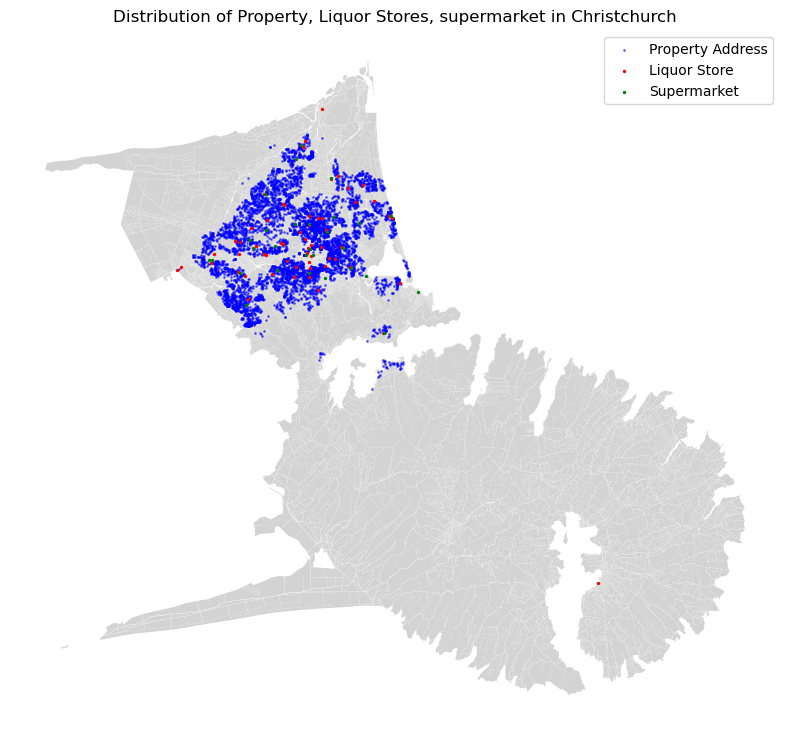

In [13]:
# target_crs = roads.crs
# liquor_store = liquor_store.to_crs(target_crs)
# property_address = property_address.to_crs(target_crs)
# supermarket=supermarket.to_crs(target_crs)

fig, ax = plt.subplots(figsize=(8, 8))

roads.plot(ax=ax, color='lightgrey', linewidth=0.5, label='Roads')
property_address.plot(ax=ax, color='blue', markersize=1, label='Property Address',alpha=0.5)
liquor_store.plot(ax=ax, color='red', markersize=2, label='Liquor Store')
supermarket.plot(ax=ax, color='green', markersize=2, label='Supermarket')

plt.legend()
plt.title("Distribution of Property, Liquor Stores, supermarket in Christchurch")
plt.axis('off')
plt.tight_layout()

plt.show()

# Geopandas distribution of unit price of house

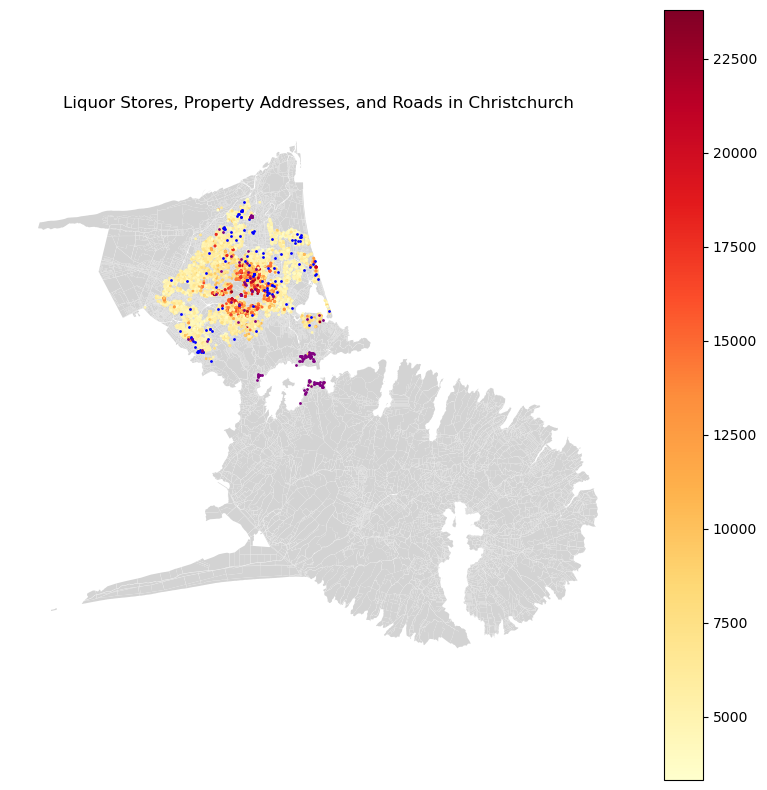

In [14]:
property_address['unit_price']=property_address['sale_price']/property_address['building_area']

# target_crs = roads.crs
# liquor_store = liquor_store.to_crs(target_crs)
# property_address = property_address.to_crs(target_crs)
# supermarket=supermarket.to_crs(target_crs)

vmin = property_address['unit_price'].quantile(0.02)
vmax = property_address['unit_price'].quantile(0.98)

low = property_address[property_address['unit_price'] < vmin]
mid = property_address[(property_address['unit_price'] >= vmin) & (property_address['unit_price'] <= vmax)]
high = property_address[property_address['unit_price'] > vmax]

fig, ax = plt.subplots(figsize=(8, 8))

roads.plot(ax=ax, color='lightgrey', linewidth=0.5, label='Roads')
mid.plot(ax=ax, column='unit_price', cmap='YlOrRd', markersize=1, vmin=vmin, vmax=vmax, legend=True)
# liquor_store.plot(ax=ax, color='black', markersize=5, label='Liquor Store')
# supermarket.plot(ax=ax, color='green', markersize=5, label='Supermarket')
low.plot(ax=ax, color='blue', markersize=1, label='Below 2%')
high.plot(ax=ax, color='purple', markersize=1, label='Above 98%')

plt.title("Liquor Stores, Property Addresses, and Roads in Christchurch")
plt.axis('off')
plt.tight_layout()

plt.show()

# Correlation of variables

In [55]:
display(Math(r'''
R = 
\begin{bmatrix}
1 & r_{12} & \cdots & r_{1p} \\
r_{21} & 1 & \cdots & r_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
r_{p1} & r_{p2} & \cdots & 1
\end{bmatrix}, 
\quad
r_{ij} = \frac{\mathrm{cov}(X_i, X_j)}{\sigma_{X_i} \sigma_{X_j}}
'''))


<IPython.core.display.Math object>

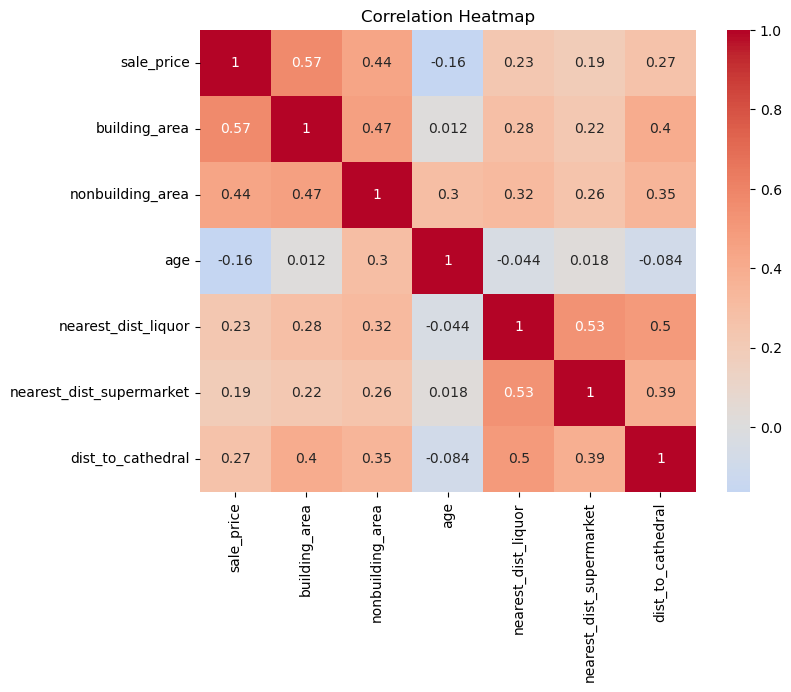

In [15]:
variables=['sale_price','building_area','nonbuilding_area','age','nearest_dist_liquor','nearest_dist_supermarket','dist_to_cathedral']
df=property_address[variables]

corr = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

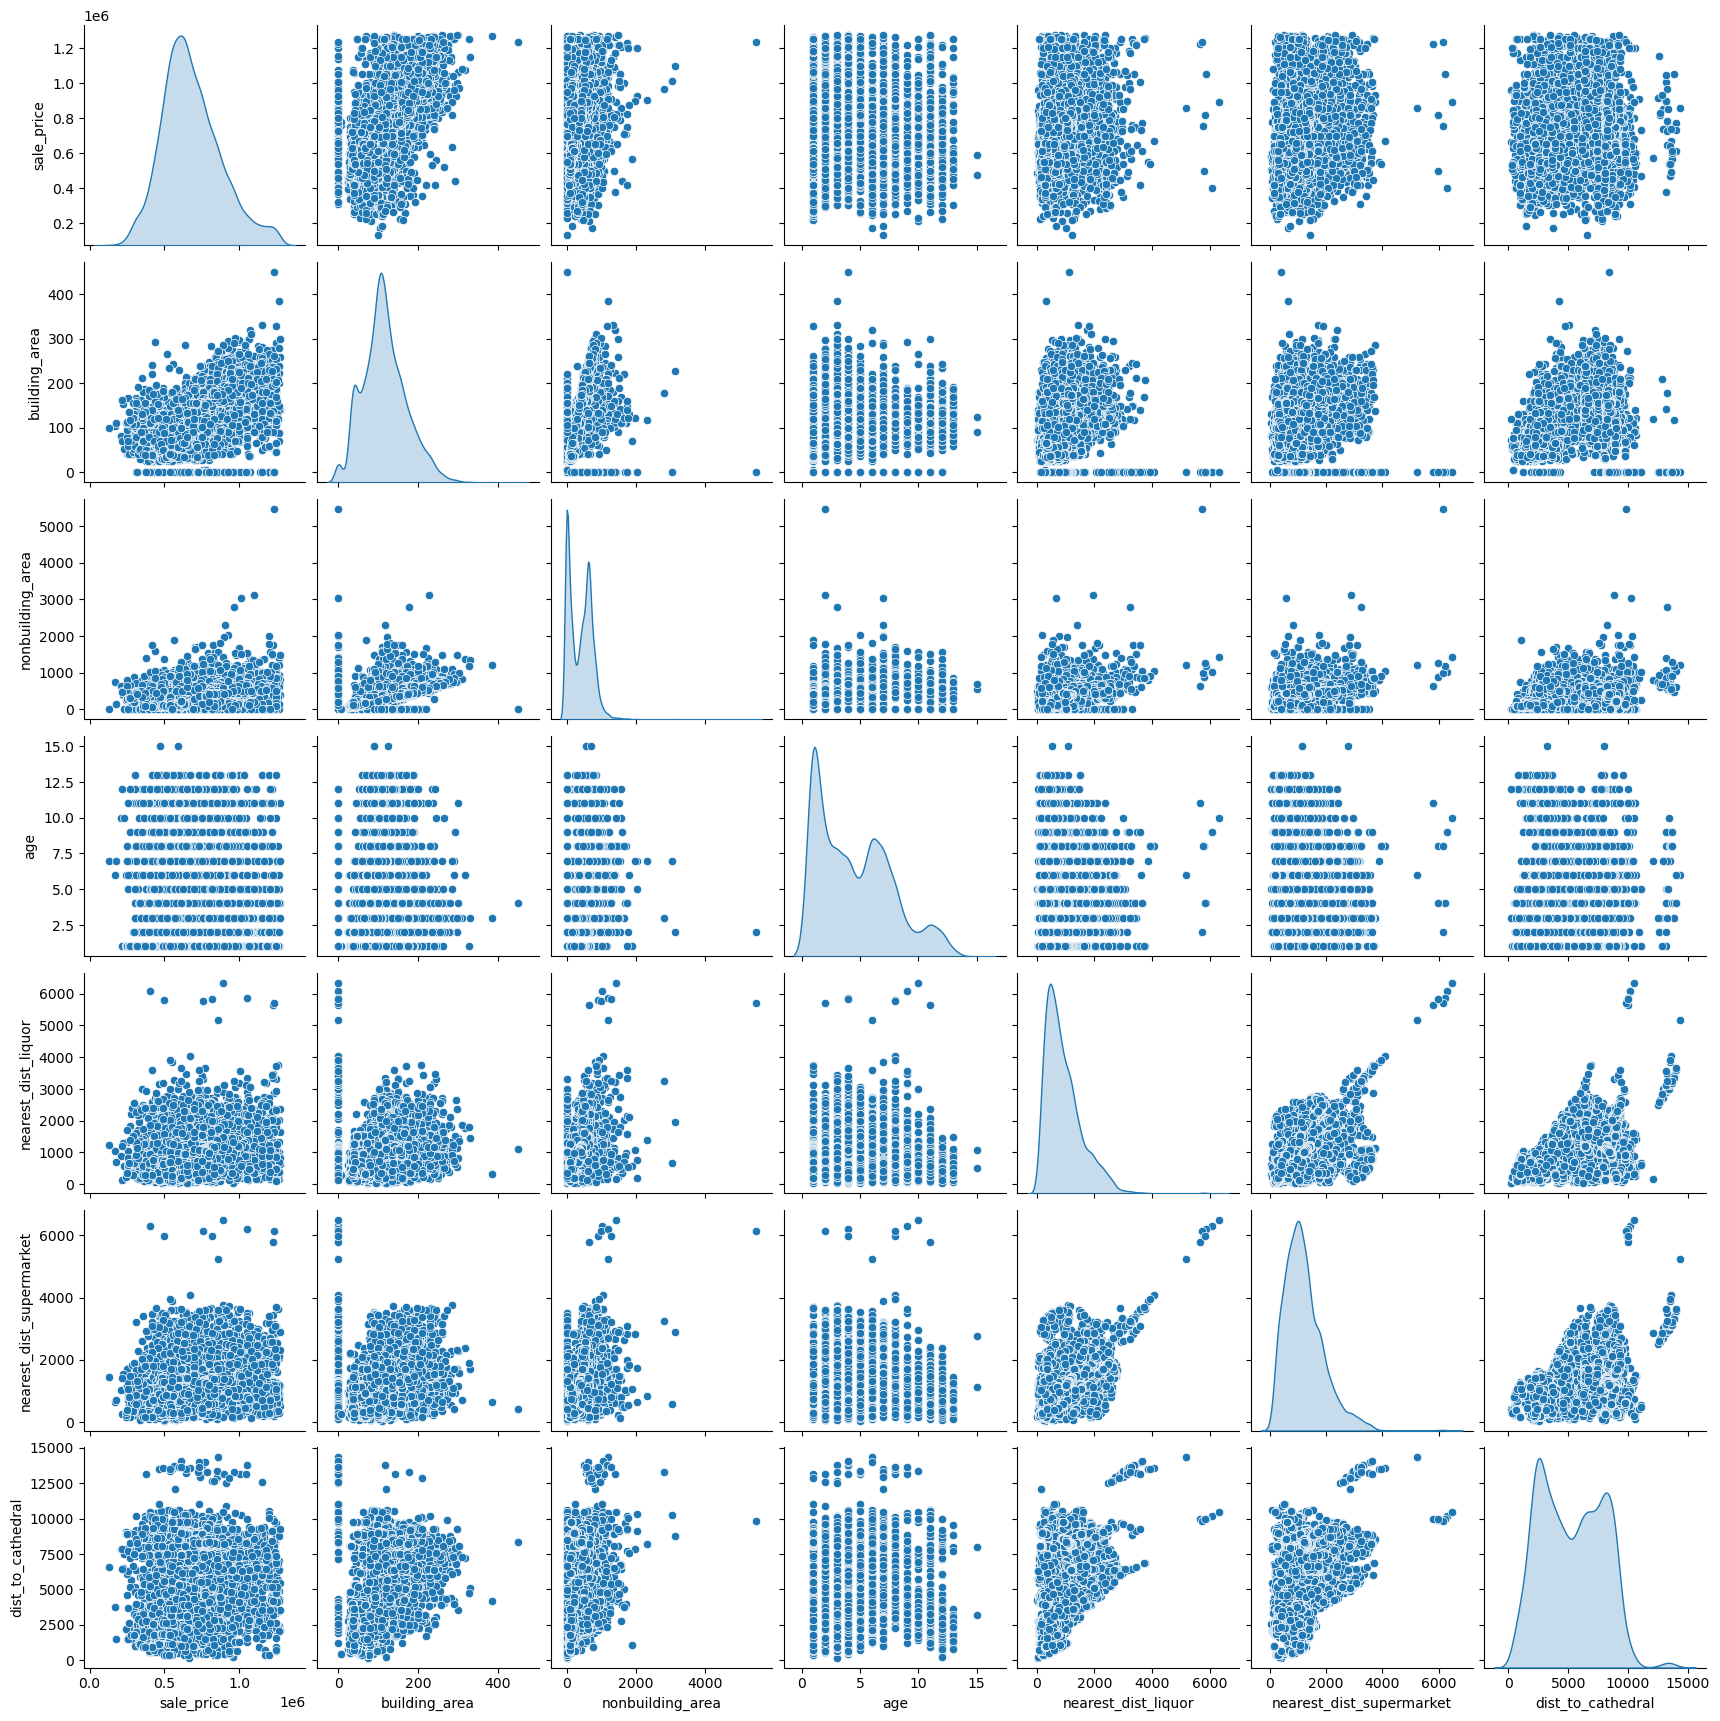

In [16]:
sns.pairplot(df,diag_kind="kde") 
plt.show()

# Modelling

In [17]:
#【Optional】 Log Transformation on data

In [18]:
cols_to_log = [
    'sale_price',
    'building_area',
    'nonbuilding_area',
    'nearest_dist_liquor',
    'nearest_dist_supermarket',
    'dist_to_cathedral'
]

for col in cols_to_log:
    property_address[col] = np.log(property_address[col].replace(0, 1))

### Examine data for muticollinearity, using VIF

In [54]:
display(Math(r'\mathrm{VIF}_j = \frac{1}{1 - R_j^2}'))

<IPython.core.display.Math object>

In [19]:
def calculate_vif(X):
    vif_dict = {}
    for i in range(X.shape[1]):
        y = X.iloc[:, i]
        X_other = X.drop(X.columns[i], axis=1)
        coef = np.linalg.lstsq(X_other, y, rcond=None)[0]
        y_pred = X_other.dot(coef)
        ss_res = ((y - y_pred)**2).sum()
        ss_tot = ((y - y.mean())**2).sum()
        r_squared = 1 - ss_res/ss_tot
        vif = 1 / (1 - r_squared)
        vif_dict[X.columns[i]] = vif
    return pd.DataFrame.from_dict(vif_dict, orient='index', columns=['VIF'])

data = property_address[['building_area','nonbuilding_area','age','nearest_dist_liquor','nearest_dist_supermarket','dist_to_cathedral']]

vif_result = calculate_vif(data)
print(vif_result)

                               VIF
building_area             1.052642
nonbuilding_area          1.077567
age                       1.000270
nearest_dist_liquor       1.481009
nearest_dist_supermarket  1.087638
dist_to_cathedral         0.923545


### Models

In [53]:
display(Math(r'y_i = \beta_0(u_i,v_i) + \sum_{k=1}^{p} \beta_k(u_i,v_i) x_{ik} + \varepsilon_i'))
display(Math(r'''
\boldsymbol{\hat{\beta}}(u_i,v_i) = (\mathbf{X}^T \mathbf{W}(u_i,v_i) \mathbf{X})^{-1} \mathbf{X}^T \mathbf{W}(u_i,v_i)
'''))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
property_address['geometry'] = property_address['geometry']
gdf_property = gpd.GeoDataFrame(property_address, geometry='geometry')
Y = gdf_property['sale_price'].values.reshape((-1, 1))
X = gdf_property[['building_area', 'nonbuilding_area', 'age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']].values
X = StandardScaler().fit_transform(X)
coords = np.array([[point.y, point.x] for point in gdf_property.geometry])

selector = Sel_BW(coords, Y, X)
bw = selector.search() 

print(f'Optimal bandwidth: {bw}')

gwr_model = GWR(coords, Y, X, bw)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

Optimal bandwidth: 87.0
Model type                                                         Gaussian
Number of observations:                                                6554
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            389.055
Log-likelihood:                                                     -45.118
AIC:                                                                104.236
AICc:                                                               106.258
BIC:                                                             -57144.873
R2:                                                                   0.308
Adj. R2:                                                              0.307

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ----

### Boxplot of coefficient

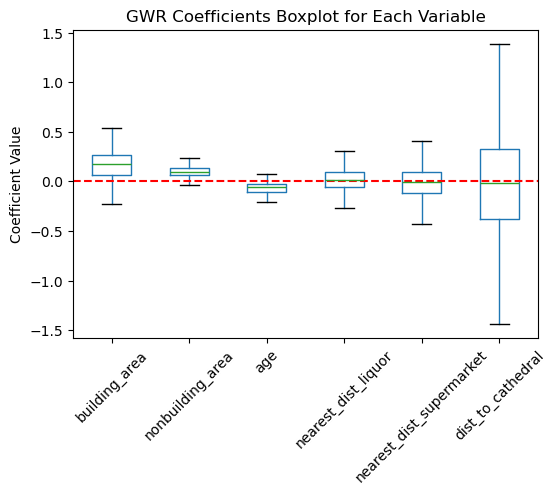

In [21]:
params = gwr_results.params  # shape (n_points, n_variables)
variables = ['Intercept', 'building_area', 'nonbuilding_area', 'age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']

df_params = pd.DataFrame(params, columns=variables)

df_params_no_intercept = df_params.drop(columns=['Intercept'])

plt.figure(figsize=(6,4))
df_params_no_intercept.boxplot(showfliers=False)
plt.axhline(0,color='red', linestyle='--')
plt.title('GWR Coefficients Boxplot for Each Variable')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

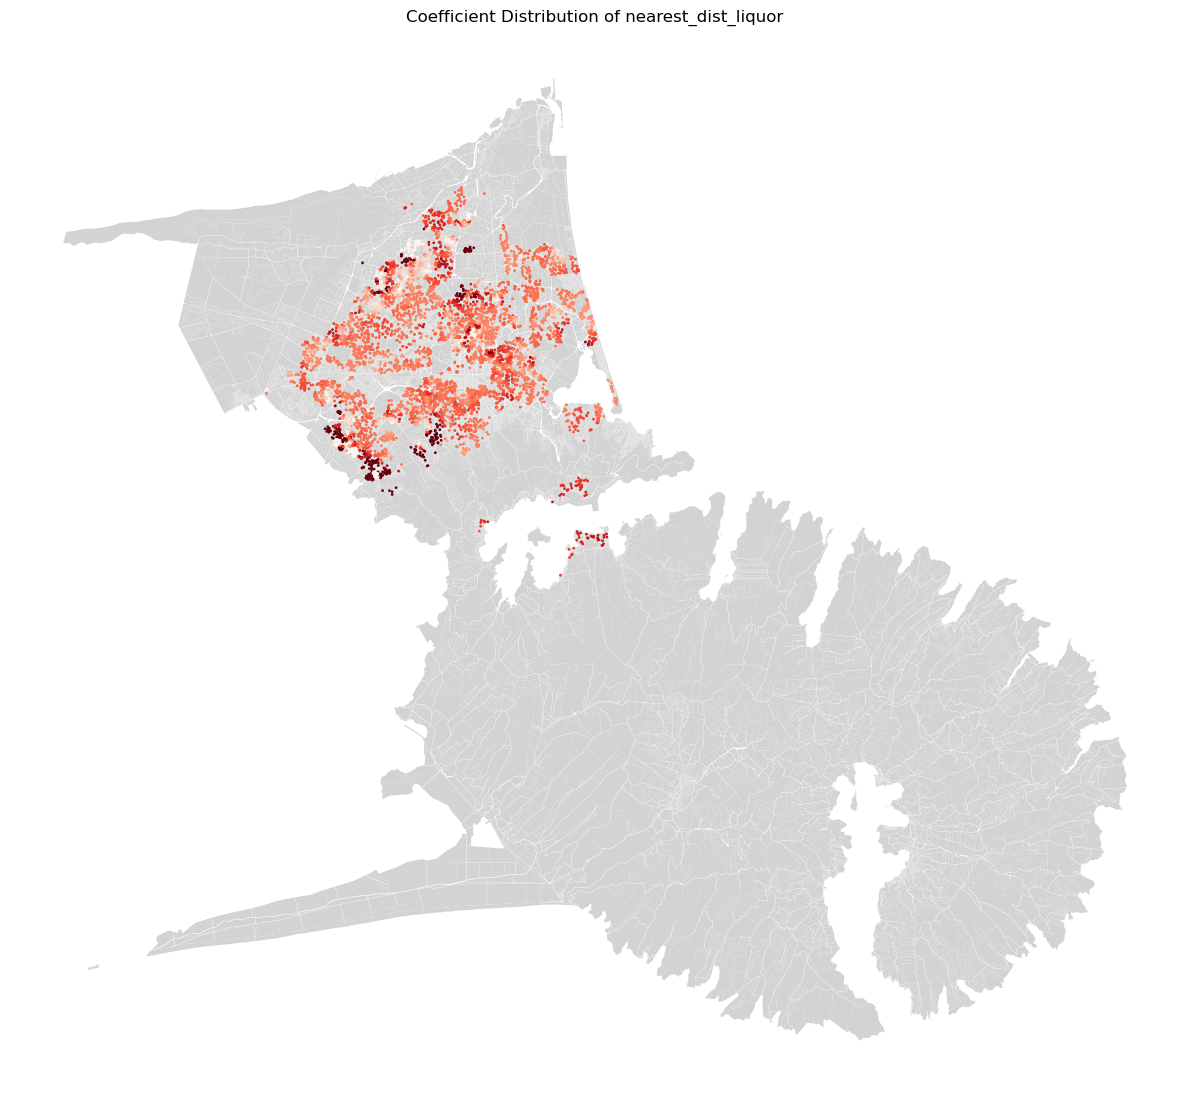

In [24]:
variables = ['building_area', 'nonbuilding_area', 'age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']
merged=pd.merge(property_address.iloc[:,2:3],df_params_no_intercept,left_index=True, right_index=True)

lower, upper = merged['nearest_dist_liquor'].quantile([0.05, 0.95])
merged['nearest_dist_liquor'] = merged['nearest_dist_liquor'].clip(lower, upper)

plt.figure(figsize=(12,12))
ax=plt.gca()
roads.plot(ax=ax, color='lightgrey', linewidth=0.5)
merged.plot(column='nearest_dist_liquor',ax=ax,cmap="Reds",markersize=1)
plt.title("Coefficient Distribution of nearest_dist_liquor")
plt.axis("off")

plt.tight_layout()
plt.show()

### Moran's I of coefficient of nearest_dist_liquor

In [28]:
y = merged['nearest_dist_liquor'].values

# Queen 
w_queen = Queen.from_dataframe(property_address,use_index=True)
moran_queen = Moran(y, w_queen)
print("Queen:")
print("Moran's I:", moran_queen.I)
print("p-value  :", moran_queen.p_sim)
print("")


Queen:
Moran's I: 0.7715682375248456
p-value  : 0.001



# Residual Analysis

### Distributon of Residuals

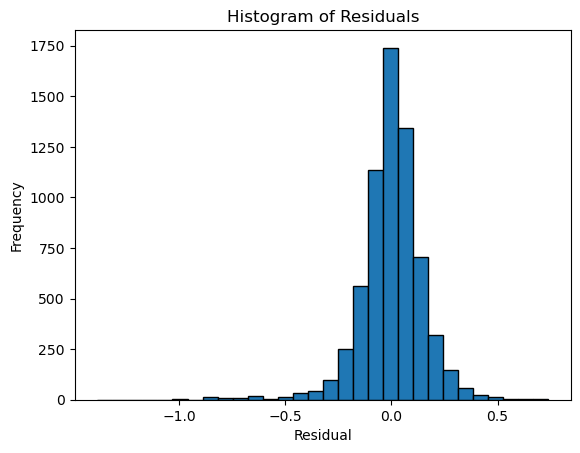

In [31]:
residuals = gwr_results.resid_response.flatten() 
gdf_property['residuals'] = residuals.flatten()
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### Jarque Bera Test for Normality

In [35]:
from scipy.stats import jarque_bera

stat, p = jarque_bera(residuals)
print(f"JB test statistic={stat:.3f}, p-value={p:.3f}") 

JB test statistic=17442.895, p-value=0.000


### Independency Test

In [38]:
w = KNN.from_dataframe(gdf_property, k=8)
w.transform = 'r'

moran = Moran(gdf_property['residuals'], w)

print(f"Moran's I: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

D:\anaconda3\envs\gis_env\lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I: -0.0144
p-value: 0.0020


# Model equation

In [40]:
i = 110
coef = gwr_results.params[i]
variables = ['Intercept', 'building_area', 'nonbuilding_area','age', 'nearest_dist_liquor', 'nearest_dist_supermarket','dist_to_cathedral']
formula_parts = [f"{coef[j]:.3f}*{variables[j]}" if j > 0 else f"{coef[j]:.3f}" for j in range(len(coef))]
formula_str = " + ".join(formula_parts)
print(f"y = {formula_str}")

y = 14.383 + 0.055*building_area + 0.074*nonbuilding_area + -0.174*age + -0.065*nearest_dist_liquor + 0.051*nearest_dist_supermarket + -0.934*dist_to_cathedral


# Predictive Performance

In [47]:
display(Math(r'\mathrm{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\%'))

<IPython.core.display.Math object>

In [44]:
y_pred = gwr_results.predy.flatten()
y_true = Y.flatten()

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 0.78%
